In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
import seaborn as sns

In [2]:
df_book=pd.read_csv("dataset/Book reviews/Book reviews/BX_Books.csv",sep=';',encoding = 'latin-1')
df_rating=pd.read_csv("dataset/Book reviews/Book reviews/BX-Book-Ratings.csv",sep=';',encoding = 'latin-1')
# df_processed=pd.read_csv("dataset/Books Data with Category Language and Summary/Preprocessed_data.csv",sep=';',encoding = 'latin-1')

## Data exploration

In [3]:
print(df_book.dtypes)
print('\n')
print(df_rating.dtypes)

ISBN                   object
Book-Title             object
Book-Author            object
Year-Of-Publication     int64
Publisher              object
Image-URL-S            object
Image-URL-M            object
Image-URL-L            object
dtype: object


User-ID         int64
ISBN           object
Book-Rating     int64
dtype: object


In [4]:
df_book.describe()

,Year-Of-Publication
count,271379.000000
mean,1959.756050
std,258.011363
min,0.000000
25%,1989.000000
50%,1995.000000
75%,2000.000000
max,2050.000000


In [5]:
df_rating.describe()


,User-ID,Book-Rating
count,1.149780e+06,1.149780e+06
mean,1.403864e+05,2.866950e+00
std,8.056228e+04,3.854184e+00
min,2.000000e+00,0.000000e+00
25%,7.034500e+04,0.000000e+00
50%,1.410100e+05,0.000000e+00
75%,2.110280e+05,7.000000e+00
max,2.788540e+05,1.000000e+01


In [6]:
df_rating['Book-Rating'].value_counts()

0     716109
8     103736
10     78610
7      76457
9      67541
5      50974
6      36924
4       8904
3       5996
2       2759
1       1770
Name: Book-Rating, dtype: int64

C:\Users\ChungHyunwoo\AppData\Local\Temp\ipykernel_23224\2710639023.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_rating['Book-Rating'])


<AxesSubplot: xlabel='Book-Rating', ylabel='Density'>

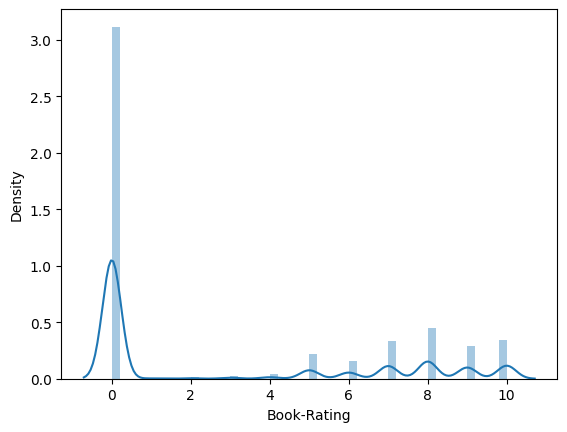

In [7]:
sns.distplot(df_rating['Book-Rating'])

## Data preprocessing

In [8]:
# Replace rating 0 into NaN
df_rating.replace(0,np.nan,inplace=True)

In [9]:
df_rating['Book-Rating'].value_counts()


8.0     103736
10.0     78610
7.0      76457
9.0      67541
5.0      50974
6.0      36924
4.0       8904
3.0       5996
2.0       2759
1.0       1770
Name: Book-Rating, dtype: int64

In [10]:
# Merge datasets
user_book_rating=pd.merge(df_book,df_rating,on="ISBN")
print(user_book_rating.isnull().sum())
user_book_rating['User-ID'].value_counts()

ISBN                        0
Book-Title                  0
Book-Author                 1
Year-Of-Publication         0
Publisher                   2
Image-URL-S                 0
Image-URL-M                 0
Image-URL-L                 0
User-ID                     0
Book-Rating            647323
dtype: int64


11676     11144
198711     6456
153662     5814
98391      5779
35859      5646
          ...  
72897         1
51911         1
151772        1
158802        1
259920        1
Name: User-ID, Length: 92107, dtype: int64

In [11]:
len(user_book_rating['Book-Title'].unique())

241090

In [12]:
# Total rating count on each books
book_ratingCount = (user_book_rating.
     groupby(by = ['Book-Title'])['Book-Rating'].
     count().
     reset_index().
     rename(columns = {'Book-Rating': 'totalRatingCount'})
     [['Book-Title', 'totalRatingCount']]
    )
book_ratingCount.head()

,Book-Title,totalRatingCount
0,A Light in the Storm: The Civil War Diary of ...,1
1,Always Have Popsicles,0
2,Apple Magic (The Collector's series),0
3,"Ask Lily (Young Women of Faith: Lily Series, ...",1
4,Beyond IBM: Leadership Marketing and Finance ...,0


In [13]:
# Merge rating count
rating_with_totalRatingCount = user_book_rating.merge(book_ratingCount, left_on = 'Book-Title', right_on = 'Book-Title', how = 'left')
rating_with_totalRatingCount.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating,totalRatingCount
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,2,NaN,1
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,8,5.0,9
2,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,11400,NaN,9
3,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,11676,8.0,9
4,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,41385,NaN,9


In [14]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(book_ratingCount['totalRatingCount'].describe())

count   241090.000
mean         1.592
std          6.993
min          0.000
25%          0.000
50%          1.000
75%          1.000
max        707.000
Name: totalRatingCount, dtype: float64


In [15]:
# Extract books with totalRatingCount>=50
popularity_threshold = 50
rating_popular_book = rating_with_totalRatingCount.query('totalRatingCount >= @popularity_threshold')
rating_popular_book.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating,totalRatingCount
30,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...,8,NaN,116
31,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...,11676,9.000,116
32,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...,29526,9.000,116
33,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...,36836,NaN,116
34,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...,46398,9.000,116


In [16]:
# Show value count on features
print(rating_popular_book['User-ID'].value_counts())
print(rating_popular_book['Book-Title'].value_counts())

11676     886
35859     402
16795     315
238120    304
153662    286
         ... 
32942       1
1108        1
271471      1
271087      1
228196      1
Name: User-ID, Length: 35223, dtype: int64
Wild Animus                                                     2502
The Lovely Bones: A Novel                                       1295
The Da Vinci Code                                                898
A Painted House                                                  838
The Nanny Diaries: A Novel                                       828
                                                                ... 
Jitterbug Perfume                                                 88
Hearts In Atlantis : New Fiction                                  87
The Laughing Corpse (Anita Blake Vampire Hunter (Paperback))      87
The Hobbit                                                        80
Free                                                              56
Name: Book-Title, Length: 651, dtype: int64


In [17]:
# Create pivot table (Book-Title/User-ID) filled with rating values

book_user_rating=rating_popular_book.pivot_table('Book-Rating',index='Book-Title',columns='User-ID')
book_user_rating.head()

User-ID,9,16,26,32,42,51,91,97,99,114,...,278800,278807,278824,278828,278832,278836,278843,278844,278846,278854
Book-Title,,,,,,,,,,,,,,,,,,,,,
1984,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1st to Die: A Novel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2nd Chance,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4 Blondes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
84 Charing Cross Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:

print(len(book_user_rating))
print(len(book_user_rating.columns))

651
24863


In [19]:
# Fill NAN into 0.0
book_user_rating.fillna(0,inplace=True)
book_user_rating.head(3)

User-ID,9,16,26,32,42,51,91,97,99,114,...,278800,278807,278824,278828,278832,278836,278843,278844,278846,278854
Book-Title,,,,,,,,,,,,,,,,,,,,,
1984,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1st to Die: A Novel,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2nd Chance,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [20]:
# train, testset split
trainset,testset = train_test_split(book_user_rating.T, test_size=0.0005,random_state=1)
trainset=trainset.T
testset=testset.T

trainset=trainset.dropna()

In [21]:
similarity_matrix=cosine_similarity(trainset)
similarity_matrix=pd.DataFrame(data=similarity_matrix,index=trainset.index,columns=trainset.index)
similarity_matrix.head()

Book-Title,1984,1st to Die: A Novel,2nd Chance,4 Blondes,84 Charing Cross Road,A Beautiful Mind: The Life of Mathematical Genius and Nobel Laureate John Nash,A Bend in the Road,A Case of Need,"A Child Called \It\"": One Child's Courage to Survive""",A Confederacy of Dunces (Evergreen Book),...,Wifey,Wild Animus,Winter Solstice,Wish You Well,Without Remorse,"Wizard and Glass (The Dark Tower, Book 4)",Wuthering Heights,Year of Wonders,Zen and the Art of Motorcycle Maintenance: An Inquiry into Values,"\O\"" Is for Outlaw"""
Book-Title,,,,,,,,,,,,,,,,,,,,,
1984,1.000,0.023,0.007,0.000,0.033,0.014,0.013,0.041,0.019,0.022,...,0.026,0.018,0.014,0.020,0.011,0.049,0.028,0.023,0.039,0.016
1st to Die: A Novel,0.023,1.000,0.163,0.000,0.009,0.000,0.032,0.027,0.030,0.006,...,0.025,0.009,0.035,0.061,0.035,0.025,0.025,0.019,0.014,0.056
2nd Chance,0.007,0.163,1.000,0.011,0.009,0.000,0.042,0.047,0.000,0.018,...,0.051,0.025,0.033,0.049,0.009,0.049,0.011,0.017,0.009,0.033
4 Blondes,0.000,0.000,0.011,1.000,0.000,0.000,0.000,0.037,0.000,0.012,...,0.031,0.002,0.000,0.000,0.000,0.003,0.023,0.025,0.010,0.000
84 Charing Cross Road,0.033,0.009,0.009,0.000,1.000,0.021,0.008,0.029,0.010,0.039,...,0.023,0.025,0.021,0.022,0.014,0.025,0.017,0.000,0.011,0.035


In [22]:
similarity_matrix['1st to Die: A Novel'].sort_values(ascending=False)[:5]

Book-Title
1st to Die: A Novel                 1.000
2nd Chance                          0.163
Roses Are Red (Alex Cross Novels)   0.143
Violets Are Blue                    0.138
Kiss the Girls                      0.126
Name: 1st to Die: A Novel, dtype: float64

In [23]:
# Use KNN algorithm with cosine similarity metric
knn=NearestNeighbors(metric='cosine',algorithm='brute')
knn.fit(book_user_rating.values)
distances, indices=knn.kneighbors(book_user_rating.values,n_neighbors=3)
print(indices)
print(distances)

[[  0  51  85]
 [  1   2 371]
 [  2   1 620]
 ...
 [648 292 593]
 [649  57 185]
 [650 210  92]]
[[4.44089210e-16 8.44175106e-01 8.63022413e-01]
 [0.00000000e+00 8.36555091e-01 8.56674030e-01]
 [0.00000000e+00 8.36555091e-01 8.40768556e-01]
 ...
 [3.33066907e-16 9.19586846e-01 9.24079319e-01]
 [0.00000000e+00 9.07466512e-01 9.29253912e-01]
 [3.33066907e-16 8.04459732e-01 8.15560032e-01]]


In [24]:
# Create dataframe to write predicted rating
predicted_df=pd.concat([trainset,testset],axis=1)

In [25]:
# Function predicts rating of target user
def itembased_predict_rating(df,user_id,number_neighbors,count):
  
  # find the nearest neighbors using KNN
  # compute similarity with cosine similarity
  knn = NearestNeighbors(metric='cosine', algorithm='brute')
  knn.fit(df.values)
  distances, indices = knn.kneighbors(df.values, n_neighbors=number_neighbors)

  # convert user_id to user_index
  user_index = df.columns.tolist().index(user_id)
  # t: book_title, m: the row number of t in df
  for m,t in list(enumerate(df.index)):
    
    # find books without ratings by target user
    if df.iloc[m, user_index] == 0:
      sim_books = indices[m].tolist()
      book_distances = distances[m].tolist()
      
      # Generally, this is the case: indices[3] = [3 6 7]. The book itself is in the first place.
      # In this case, we take off 3 from the list. Then, indices[3] == [6 7] to have the nearest NEIGHBORS in the list. 
      if m in sim_books:
        id_book = sim_books.index(m)
        sim_books.remove(m)
        book_distances.pop(id_book) 

      # However, if the percentage of ratings in the dataset is very low, there are too many 0s in the dataset. 
      # Some books have all 0 ratings and the books with all 0s are considered the same books by NearestNeighbors(). 
      # Then,even the book itself cannot be included in the indices. 
      # For example, indices[3] = [2 4 7] is possible if book_2, book_3, book_4, and book_7 have all 0s for their ratings.
      # In that case, we take off the farthest book in the list. Therefore, 7 is taken off from the list, then indices[3] == [2 4].
      else:
        sim_books = sim_books[:number_neighbors-1]
        book_distances = book_distances[:number_neighbors-1]
          
      # book_similarty = 1 - book_distance    
      book_similarity = [1-x for x in book_distances]
      book_similarity_copy = book_similarity.copy()
      nominator = 0

      # for each similar book
      for s in range(0, len(book_similarity)):
        
        # check if the rating of a similar book is zero
        if df.iloc[sim_books[s], user_index] == 0:

          # if the rating is zero, ignore the rating and the similarity in calculating the predicted rating
          if len(book_similarity_copy) == (number_neighbors - 1):
            book_similarity_copy.pop(s)
            
          else:
            book_similarity_copy.pop(s-(len(book_similarity)-len(book_similarity_copy)))

        # if the rating is not zero, use the rating and similarity in the calculation
        else:
          nominator = nominator + book_similarity[s]*df.iloc[sim_books[s],user_index]

      # check if the number of the ratings with non-zero is positive
      if len(book_similarity_copy) > 0:
        
        # check if the sum of the ratings of the similar books is positive.
        if sum(book_similarity_copy) > 0:
          predicted_r = nominator/sum(book_similarity_copy)

        # Even if there are some books for which the ratings are positive, some books have zero similarity even though they are selected as similar books.
        # in this case, the predicted rating becomes zero as well  
        else:
          predicted_r = 0

      # if all the ratings of the similar books are zero, then predicted rating should be zero
      else:
        predicted_r = 0

    # place the predicted rating into the copy of the original dataset
      predicted_df.iloc[m,user_index+count] = predicted_r

In [37]:
# Function that recommends books for each test user
def recommend_books(user, num_recommended_books):



  print('The list of the Books User_{} Have rated \n'.format(user))

  # print books that target user have rated.
  for m in testset[testset[user] > 0][user].index.tolist():
    print(m)
  
  print('\n')

  recommended_books = []

  # recommend books among empty rated books
  for m in testset[testset[user] == 0].index.tolist():

    index_df = testset.index.tolist().index(m)
    predicted_rating = predicted_df.iloc[index_df, predicted_df.columns.tolist().index(user)]
    recommended_books.append((m, predicted_rating))

  sorted_rm = sorted(recommended_books, key=lambda x:x[1], reverse=True)
  
  print('The list of the Recommended Books \n')
  rank = 1
  result = []
  for recommended_book in sorted_rm[:num_recommended_books]:
    result.append('{}: {} - predicted rating:{}'.format(rank, recommended_book[0], recommended_book[1]))
    rank = rank + 1

  return result

In [35]:
# predict ratings of test set
count=0
for target_userID in testset:
        df=trainset.copy()
        
        # Concatenate new data for predict
        df=pd.concat([trainset,testset[target_userID]],axis=1)

        # Predict empty ratings of target user
        itembased_predict_rating(df,target_userID,5,count)
        count+=1

In [38]:
recommend_books(170693,5)

The list of the Books User_170693 Have rated 

Jewels of the Sun (Irish Trilogy)
Tears of the Moon (Irish Trilogy)


The list of the Recommended Books 



['1: Face the Fire (Three Sisters Island Trilogy) - predicted rating:7.0',
 '2: Mirror Image - predicted rating:7.0',
 '3: The Divine Secrets of the Ya-Ya Sisterhood: A Novel - predicted rating:7.0',
 '4: Carolina Moon - predicted rating:6.999999999999999',
 '5: Heaven and Earth (Three Sisters Island Trilogy) - predicted rating:6.500478700406949']